## Quality Control (QC) Plotting for Single-Cell RNA-seq Data

In this notebook, we will generate and customize Quality Control (QC) plots for single-cell RNA-seq data. These plots will help us visualize various QC metrics and decide on filtering criteria for each dataset. <br>

This review was based on the [tutorial](https://www.embopress.org/doi/full/10.15252/msb.20188746) from Luecken, M. D., & Theis, F. J.

In [27]:
import matplotlib.pyplot as plt
import scanpy as sc

from bmfm_targets.datasets import (
    DatasetTransformer,
    myeloid,
    quality_control,
)

%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
factory=myeloid.MyeloidDataset
source_h5ad_file_name = '/dccstor/bmfm-targets/data/omics/transcriptome/scRNA/finetune/myeloid/h5ad/myeloid_scgpt_split.h5ad'
cell_type_label = "celltype"

### Load data

Let's start by loading the AnnData object with the raw (unprocessed) scRNA seq data for Myeloid and assigning the QC metrics to mitochondrial genes:

In [29]:
adata = sc.read_h5ad(source_h5ad_file_name)
adata = quality_control.assign_mito_qc_metrics(adata)
adata

AnnData object with n_obs × n_vars = 13178 × 3000
    obs: 'celltype', 'cancer_type', 'batch', 'split_cross', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'

Before analysing single-cell gene expression data, we must ensure that all cellular data correspond to viable cells. Cell QC is commonly performed based on three QC covariates: 
1. The number of counts per cell (count depth)
2. The number of genes expressed per cell
3. The fraction of counts from mitochondrial genes per barcode. <br> <br>

The distributions of these three QC covariates are examined for outlier peaks that are filtered out by thresholding.

## Method 1
#### 1.1 Zoom into distributions and define transform parameters

Before we start deciding on thresholds to filter the data, let's zoom in on certain parts of the histogram. We can customize zooming options with ```zoom_plot_kwargs```. We are mainly interested in visualizing the beginning of the distributions of counts per cell and number of genes, and the tail of the mitochondrial counts distribution. Key arguments are:
1. *min_counts_barcode* (default to 0) and *max_counts_barcode*
2. *min_genes_per_cell* (default to 0) and *max_genes_per_cell*
3. *min_lim_mt_counts* and *max_lim_mt_counts* <br>

Specifically for the Myeloid dataset, let's visualize the following regions:

In [4]:
zoom_plot_kwargs = {
    "min_lim_mt_counts": 1.25,
    "max_lim_mt_counts": 2.2,
    "min_counts_barcode": 1250,
    "max_counts_barcode": 1450, 
    "max_genes_per_cell": 250,
}

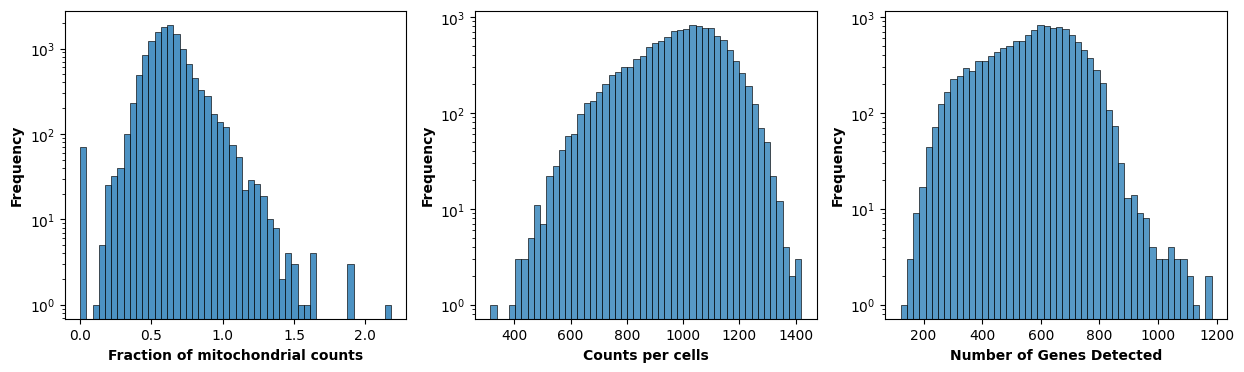

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
summary_cells_removed = {}
quality_control.plot_mito_fraction_histogram(axes[0], adata, summary_cells_removed, zoom_plot_kwargs=zoom_plot_kwargs)
quality_control.plot_counts_per_cell_histogram(axes[1], adata, summary_cells_removed, zoom_plot_kwargs=zoom_plot_kwargs)
quality_control.plot_num_genes_per_cell_histogram(axes[2], adata, summary_cells_removed, zoom_plot_kwargs=zoom_plot_kwargs)

By default, histograms will be plotted on a log scale on the y-axis, and the covariates will be log-transformed before plotting the distributions (ie, ```log_covariate=True``` by default). 

**-Counts per cell**: The minimum count for this dataset is 450. But we will remove cells with high counts, as these could represent doublets. Anything above 1200 will be removed, and you can change the x-axis limits to see the zoomed tail of the distribution. <br>

**-Number of genes detected**: Let's put a threshold at 300 and remove cells that had more than 1000 genes detected. <br>

All these thresholds can be visualized in the plots. If both thresholds are defined, the plots will include colored lines (green where it starts, red where it stops) to indicate your filtering thresholds. 

Arguments for the thresholds are tuples:

1. *mito_fraction_limits* 
2. *gene_count_limits*
3. *cell_count_limits*

In [12]:
cell_count_limits = (500, 1300)
gene_count_limits = (250, 920)

zoom_plot_kwargs = None
see_percentile_lines= False

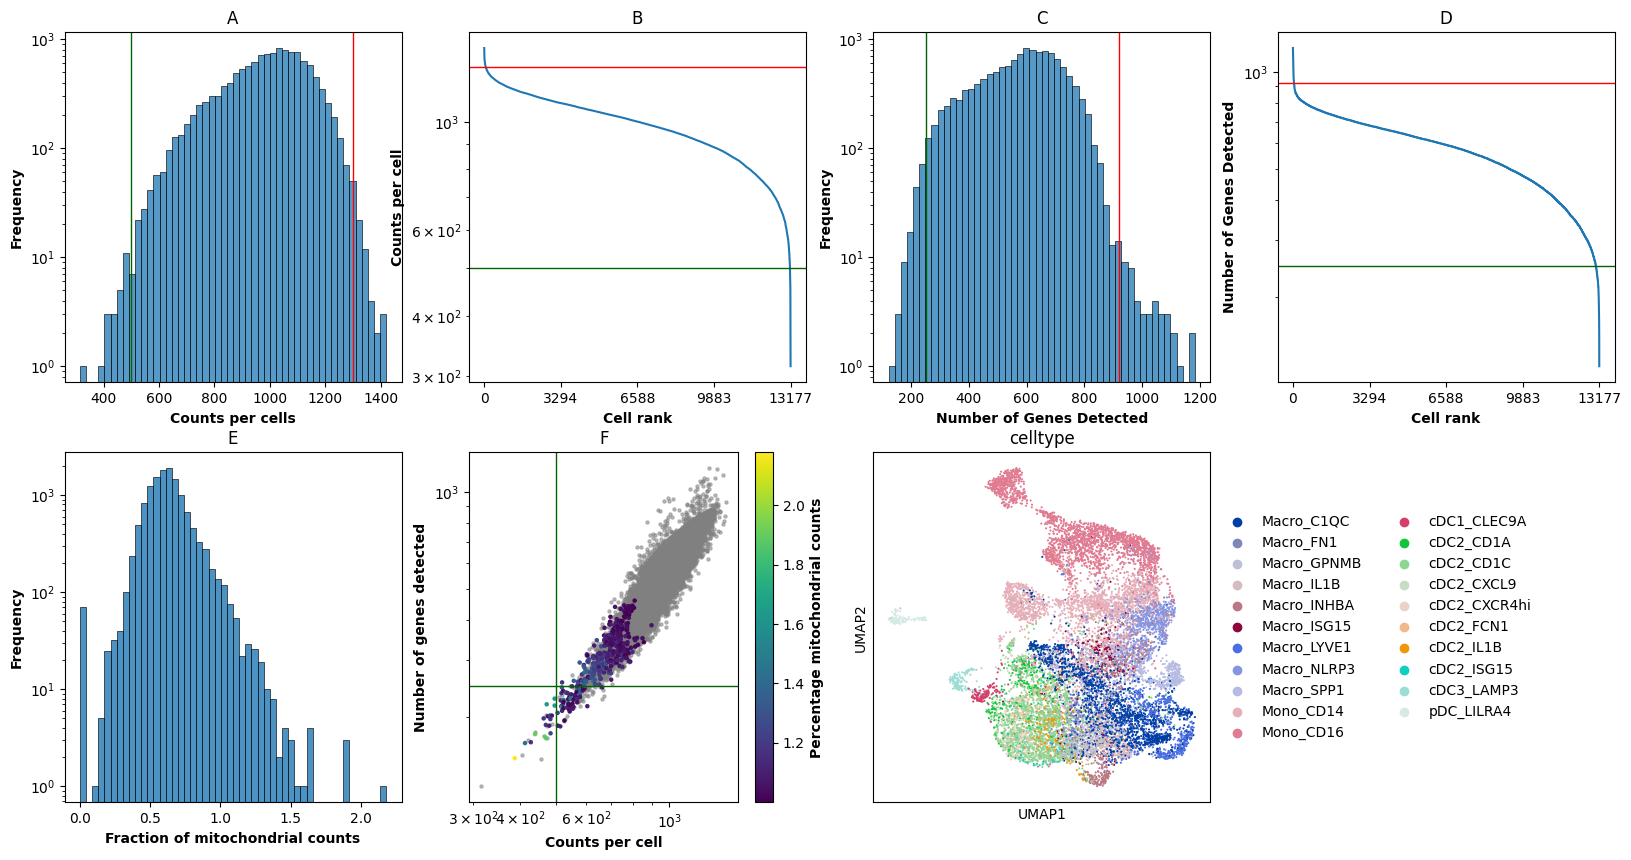

<Figure size 640x480 with 0 Axes>

In [13]:
quality_control.show_qc_plots(adata, cell_type_label = cell_type_label,  zoom_plot_kwargs=zoom_plot_kwargs, cell_count_limits = cell_count_limits,
                              gene_count_limits = gene_count_limits, 
                              )

In the plots above, panels A and B illustrate the number of counts per cell across all cells (count depth), while panels C and D display the number of genes expressed across all cells (gene counts). Panels A and C show simple histograms depicting the distribution of these two covariates, whereas panels B and D rank cells according to these covariates. This visualization reveals two 'elbows' where count depths or gene counts begin to change rapidly. This alternative view complements the histograms and helps us better define thresholds for filtering out empty droplets or potential doublets in the dataset.

In all plots, the $\textsf{\color{green}green lines}$ indicate the starting point (threshold) we selected, and the $\textsf{\color{red}red lines}$ mark the endpoint. Thus, after applying the filters, only the cells that fall **between** the green and red lines are retained, while cells beyond these thresholds are excluded. The green and red lines in plot A correspond to the same lines in plot B, and a similar relationship holds between plots C and D.

Lastly, in scatter plot F, cells with a mitochondrial fraction below the threshold (mito_fraction_limits = 8) are shown in grey, while cells with a higher fraction are represented using the colormap. Here, the green lines correspond to the same thresholds shown in the previous plots.

### 1.2. Apply transforms based on defined thresholds

After a few trials, we identified thresholds that align with the elbows. The next step is to record these thresholds under the ```DEFAULT_TRANSFORMS``` definition in the Myeloid data module. Once this is done, we can apply the transformations using the selected parameters and revisit the QC plots for visualization.


**Important**: If ```DEFAULT_TRANSFORMS``` is already defined in the factory module, you can modify it after deciding the thresholds, and run the following cell to reload the module. Every time you make changes to the factory module, you need to reload it explicitly by using %reload_ext autoreload

In [31]:
%reload_ext autoreload

In [32]:
factory.DEFAULT_TRANSFORMS

[{'transform_name': 'RenameGenesTransform',
  'transform_args': {'gene_map': None}},
 {'transform_name': 'KeepGenesTransform',
  'transform_args': {'genes_to_keep': None}},
 {'transform_name': 'FilterCellsTransform',
  'transform_args': {'min_counts': 500}},
 {'transform_name': 'FilterCellsTransform',
  'transform_args': {'max_counts': 1300}},
 {'transform_name': 'FilterCellsTransform',
  'transform_args': {'min_genes': 250}},
 {'transform_name': 'FilterCellsTransform',
  'transform_args': {'max_genes': 920}},
 {'transform_name': 'NormalizeTotalTransform',
  'transform_args': {'exclude_highly_expressed': False,
   'max_fraction': 0.05,
   'target_sum': 10000.0}},
 {'transform_name': 'LogTransform',
  'transform_args': {'base': 2, 'chunk_size': None, 'chunked': None}},
 {'transform_name': 'BinTransform',
  'transform_args': {'num_bins': 10, 'binning_method': 'int_cast'}}]

/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number
... storing 'split_random' as categorical


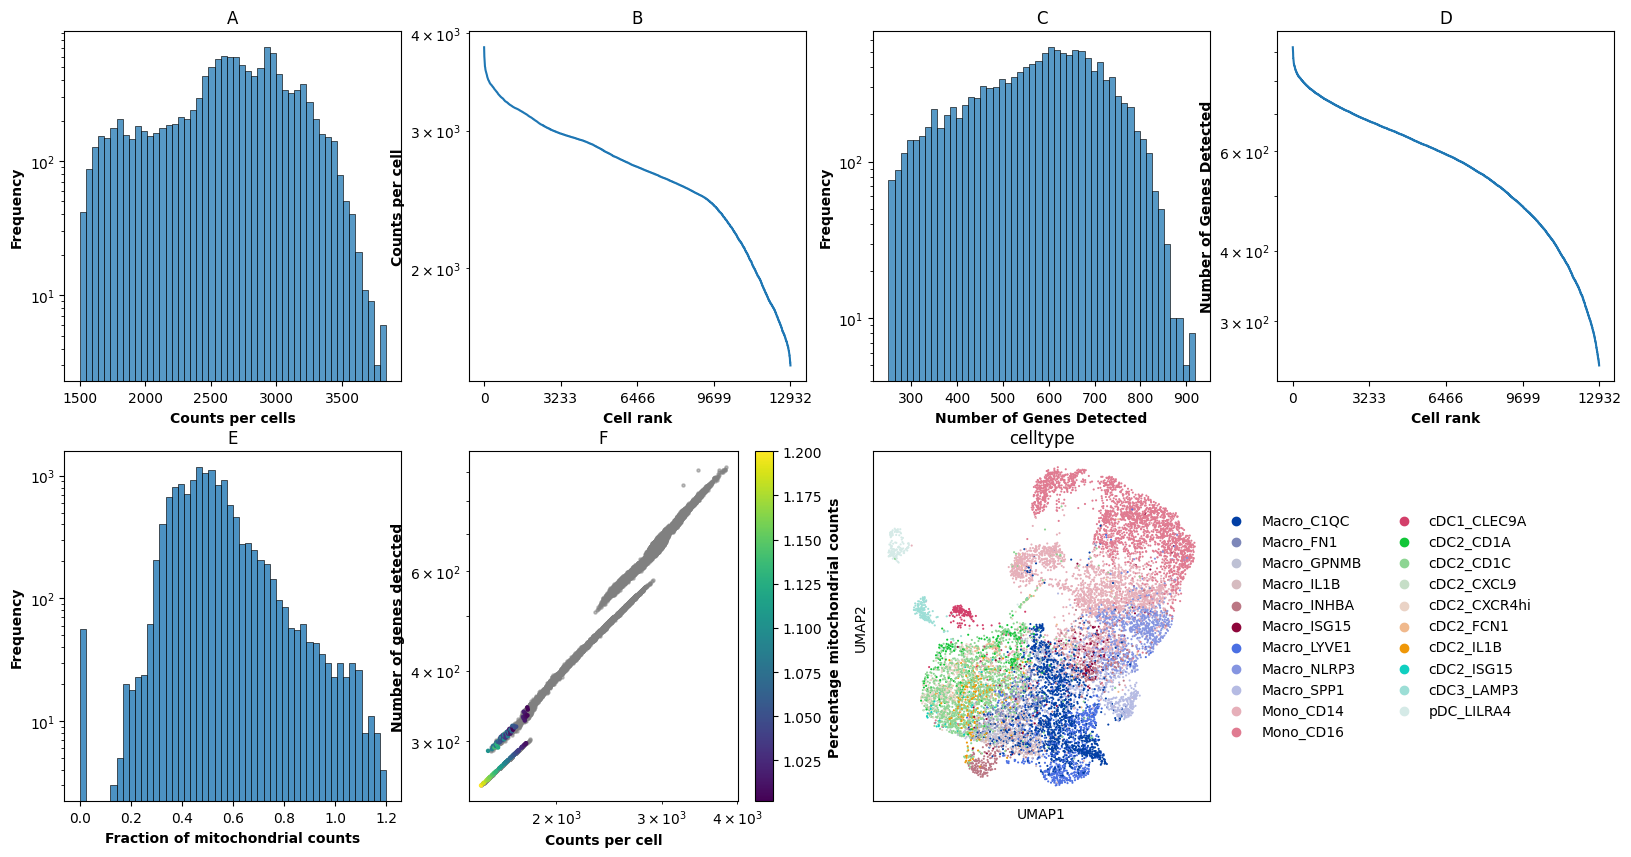

<Figure size 640x480 with 0 Axes>

In [33]:
dataset_transformer = DatasetTransformer(source_h5ad_file_name=source_h5ad_file_name,
                                         transforms=factory.DEFAULT_TRANSFORMS)
adata_transformed = dataset_transformer.process_datasets()
adata_transformed = quality_control.assign_mito_qc_metrics(adata_transformed)

zoom_plot_kwargs = None
quality_control.show_qc_plots(adata_transformed,
                               cell_type_label = cell_type_label,
                                zoom_plot_kwargs=zoom_plot_kwargs)

In plot F, we notice artifacts from the data transformation, with the 'toothpick' patterns resulting from the data binning process. Despite this, the transformations  improved the separation of certain cell types compared to the initial unprocessed dataset.

## Method 2. Cell filtering based on outlier removal

What if, as a first step, we had removed all outliers even before start filtering the data? An alternative way to do QC on single-cell is to start looking at the distributions of the covariates indiviually and visualing percentile lines in each histogram. This can be achieved by calling the individual functions below:

TypeError: plot_mito_fraction_histogram() got multiple values for argument 'see_percentile_lines'

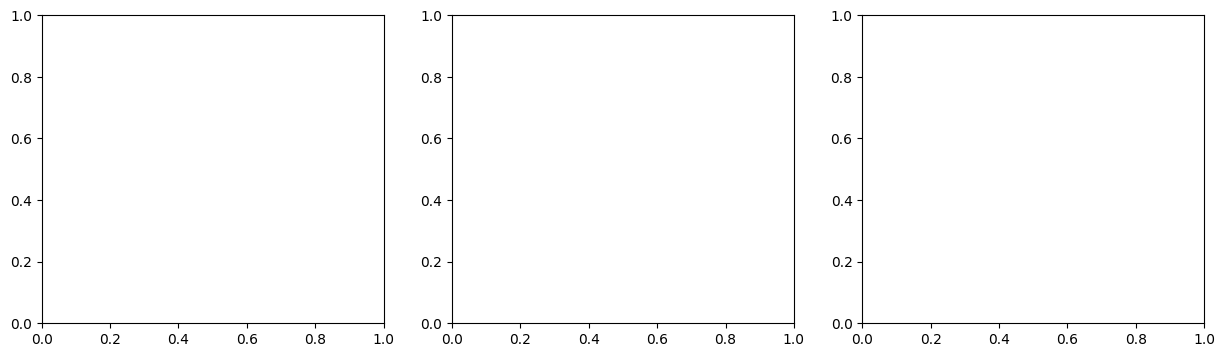

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

quality_control.plot_mito_fraction_histogram(axes[0], adata, summary_cells_removed, see_percentile_lines= True, log_covariate=True)
quality_control.plot_counts_per_cell_histogram(axes[1], adata, summary_cells_removed, see_percentile_lines= True, log_covariate=True)
quality_control.plot_num_genes_per_cell_histogram(axes[2], adata, summary_cells_removed, see_percentile_lines= True, log_covariate=True)

We can remove outliers (values below/above the median ± 1.5*IQR) from all three distributions simultaneously using the *remove_outliers* function. Given the plots above, we can see that the removal of outliers give pretty reasonable cutoffs. We will go ahead and select these cutoffs for the transforms. For simplicity, we will define the transforms in the notebook instead of rewriting them on the definition of the Myeloid module.

Number of cells removed: 806


Exception ignored in thread started by: <_pydev_bundle.pydev_monkey._NewThreadStartupWithTrace object at 0x7f32ddc34750>
Traceback (most recent call last):
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 1109, in __call__
    _on_set_trace_for_new_thread(py_db)
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_monkey.py", line 237, in _on_set_trace_for_new_thread
    global_debugger.enable_tracing()
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1107, in enable_tracing
    pydevd_tracing.SetTrace(thread_trace_func)
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd_tracing.py", line 87, in SetTrace
    if set_trace_to_threa

KeyboardInterrupt: 

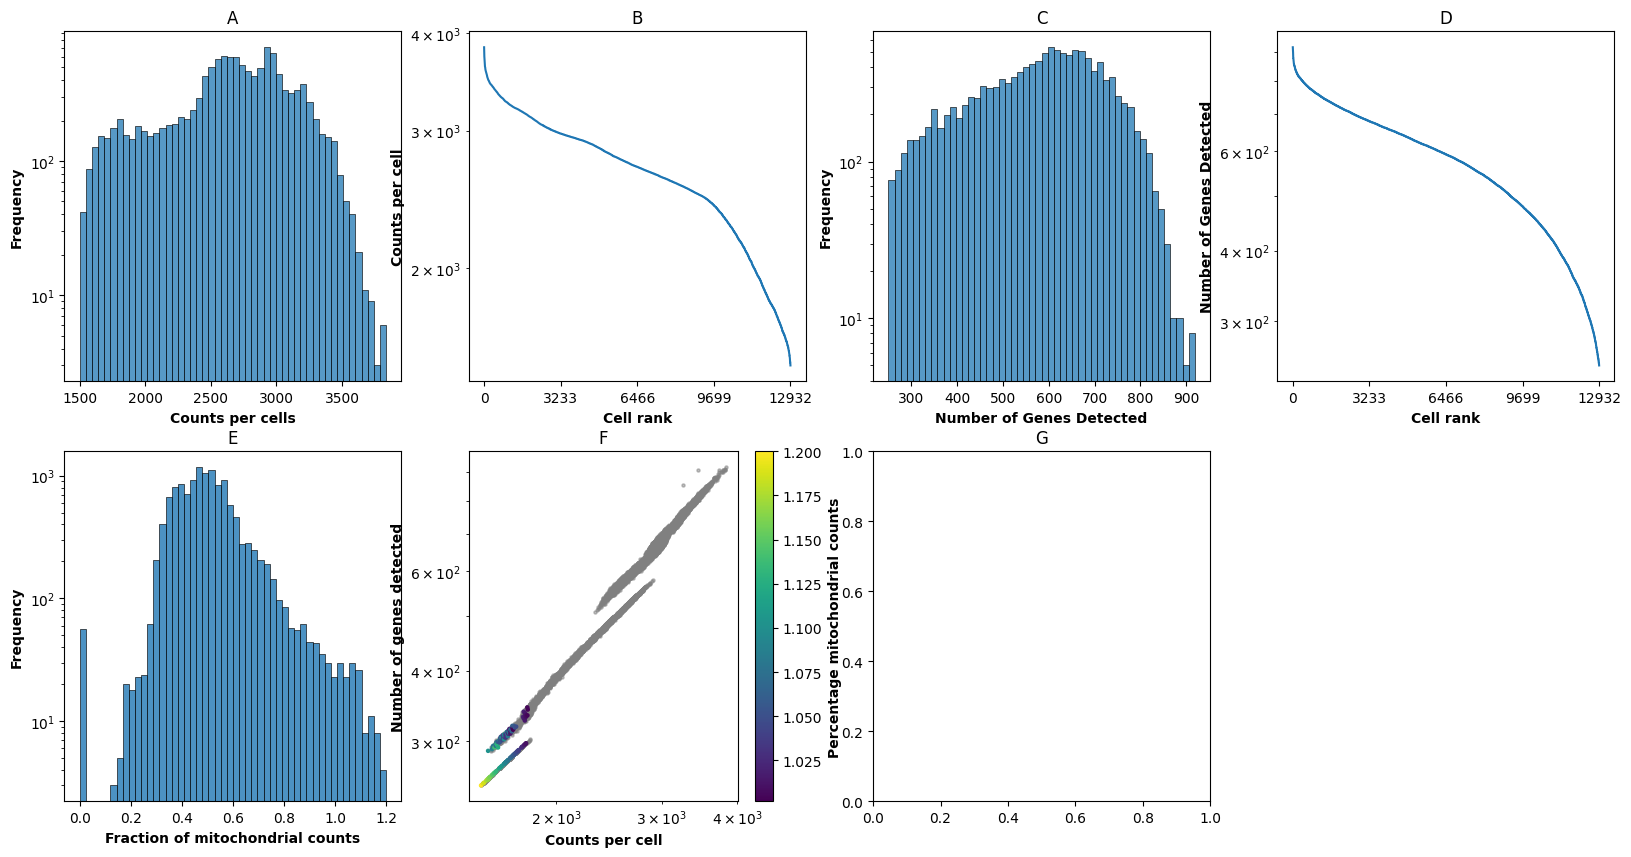

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/zmq/utils/garbage.py", line 47, in run


    if msg == b'DIE':
       ^^^
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/zmq/utils/garbage.py", line 47, in run
    if msg == b'DIE':
       ^^^
  File "_pydevd_bundle/pydevd_cython.pyx", line 1599, in _pydevd_bundle.pydevd_cython.trace_dispatch
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1107, in enable_tracing
    pydevd_tracing.SetTrace(thread_trace_func)
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendored/pydevd/pydevd_tracing.py", line 87, in SetTrace
    if set_trace_to_threads(tracing_func, thread_idents=[thread.get_ident()], create_dummy_thread=False) == 0:
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dccstor/bmfm-targets/users/talkoz/bmfm-targets/.conda-env/lib/python3.11/site-packages/debugpy/_vendor

In [38]:
adata_without_outliers = quality_control.remove_outliers(adata)
adata_transformed = quality_control.assign_mito_qc_metrics(adata_transformed)

zoom_plot_kwargs = None
quality_control.show_qc_plots(adata_transformed,
                               cell_type_label = cell_type_label,
                                zoom_plot_kwargs=zoom_plot_kwargs)